# Cognitive Science : Assignment-1
## Q1 : BOOL LEARNING
### Importing Basic Libs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output as clr
%matplotlib inline

#### Defining Boolean function

In [2]:
# Defining Boolean function 
def get_bool_data(Y): 

    '''
    Y : [y1,y2,...y8] : 8x1 vector 

    Since the function is for 3 variables we can give sequence of outputs for 2*3 = 8  possibilities in sequence.
    so input would be : Y = [y1,y2,y3,...,y8] where the mattpping would be something like:

    ---------------
    Mapping
    ---------------
    000 : y1
    001 : y2
    010 : y3
    .
    .
    111 : y8
    ---------------
    '''

    X = np.array([
        [0,0,0,Y[0]],
        [0,0,1,Y[1]],
        [0,1,0,Y[2]],
        [0,1,1,Y[3]],
        [1,0,0,Y[4]],
        [1,0,1,Y[5]],
        [1,1,0,Y[6]],
        [1,1,1,Y[7]],
    ])

    return X

In [3]:
def print_truth_table(X):
    print('inp\t| out')
    print("--"*7)
    for i in range(8):
        print(X[i,:3] , '|' , X[i,3])

In [4]:
def bool_plot_compare(Y, preds, name):
    plt.plot(X[:,3], label = 'actual')
    plt.plot(preds[0], label = 'predicted')
    plt.legend()
    plt.xticks(np.arange(8), ('000', '001', '010', '011', '100', '101', '110', '111'))
    plt.savefig(name)
    plt.show()

#### Defining A General Nueral Network Class 

In [5]:
class ann_network:
    
    '''
    -------------------------------------------------------------------------------------------------------------------------
    ||______________________________________A general deep nueral network class 2.0________________________________________||
    ||_______________________________________________by ABHISHEK KUMAR_____________________________________________________||
    ||_____________________________________________________2019____________________________________________________________||
    ||I have not copied the code from somewhere this is my own modified version of nueral network that i made 11 months ago||
    ||______________________________version 1.0 is on my github page : https://github.com/scakc ___________________________||
    '''
    ######______________________________Class Initialization____________________________#######
    def __init__(self, layers_config, lr = 0.01, max_iter = 1000):
        self.layers = layers_config
        self.parameters = self.initparams(self.layers)
        self.costs = []
        self.grads = None
        self.caches = None
        self.lr = lr
        self.epochs = max_iter
        
    def reinit(self):
        self.costs = []
        self.grads = None
        self.caches = None
        self.parameters = self.initparams(self.layers)
    
    #####_______________________________Activation Functions____________________________#######
    def relu(self,z): # in actual its a leaky relu performs better
        o = z*(z>0) - 0.1*(z<0)*z
        return o, z
    
    def drelu(self,dA,z):# in actual its a diff leaky relu performs better
        o = (z>0)*1 - 0.1*(z<0)
        return o*dA

    def sigmoid(self,z):
        o = 1/(1+np.exp(-z))
        return o, z

    def dsigmoid(self,dA,z):
        o = 1/(1+np.exp(-z))
        return (o*(1-o))*dA
    
    
    #####______________________________Parameters Initialization_______________________#######
    '''Function for initializing the network : Initialization of parameters w's and b's'''
    def initparams(self, layers):
        
        np.random.seed(15)
        parameters = {} # dictionary to contain all Ws and bs for respective layers..
        L = len(layers) # length/ depth of the network
        # NOTE : Representing w's and b's as matrices having dimensions, rows -> (i)th layer size, columns -> (i-1)th layer size:
        for l in range(1, L):
            parameters['W' + str(l)] = np.random.randn(layers[l], layers[l-1])*0.01
            parameters['b' + str(l)] = np.random.randn(layers[l], 1)+0.001
            assert(parameters['W' + str(l)].shape == (layers[l], layers[l-1]))
            assert(parameters['b' + str(l)].shape == (layers[l], 1))

        return parameters
    
    
    #####_____________________Forward Propagation of Nueral Network____________________######
    '''Single step of forward propagation in a nueral network from current to next layer...'''
    def linfwd(self,A, W, b):
        Z = np.dot(W,A) + b ##  weighted sum of outputs at next layer.
        assert(Z.shape == (W.shape[0], A.shape[1]))
        cache = (A, W, b) ## storing linear variables to help in backpropagation will be used in linback function see below...
        return Z, cache
    
    ''' Applying activation after the linfwd for non linearity'''
    def linactfwd(self,A_prev,W,b,act):
        '''
        A_prev : prev layer activations
        W : Weights
        b : biases
        act : activation function to be applied
        '''
        if act == "sigmoid":
            # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
            Z, linear_cache = self.linfwd(A_prev, W, b)
            A, activation_cache = self.sigmoid(Z)
        elif act == "relu":
            # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
            Z, linear_cache = self.linfwd(A_prev, W, b)
            A, activation_cache = self.relu(Z)

        assert (A.shape == (W.shape[0], A_prev.shape[1]))
        cache = (linear_cache, activation_cache)  # cache = ((input, W, b), (output, z)) for that layer used in linactback
        return A, cache

    '''A full forward pass over all layers..'''
    def lmodelfwd(self,X, parameters):
        '''
        X : data (input_size x no. examples)
        parameters : dictionary containing all current parameter values.
        '''
        caches = [] # list to keep caches of all layers will be used in backprop..
        
        A = X # initializing current_layer activations with inputs of network
        L = len(parameters) // 2 # number of layers in the neural network L = len(w's) + len(b's) = 2xdepth

        for l in range(1, L):
            A_prev = A 
            A, cache = self.linactfwd(A_prev,parameters['W' + str(l)],parameters['b' + str(l)],"relu")
            caches.append(cache) 

        AL, cache = self.linactfwd(A,parameters['W' + str(L)],parameters['b' + str(L)],"sigmoid")
        
        caches.append(cache)

        return AL, caches
    
    
    
    #####________________________________Loss Function Calculation___________________________#####
    '''Loss function computation after each forward pass of network..'''
    def compcost(self,AL, Y):
        '''
        AL : Activation of last layer
        Y : True Class labels
        '''
        m = Y.shape[1] # training batch size
        ### cross entropy loss has been used...
        cost = (-1/m)*(np.dot(Y,np.log(AL).T)+np.dot(1-Y,np.log(1-AL).T))
        cost = np.squeeze(cost)
        return cost
    
    
    #####____________________________Backpropagation of Nueral Network_______________________#####
    '''Single step of backprop for current layer using the caches of prev and current layers that we stored...'''
    def linback(self,dZ, cache):
        '''
        dZ : Gradient of the cost with respect to the linear output (of current layer l)
        cache : (A_prev, W, b) as we stored during forward prop..
        '''
        A_prev, W, b = cache
        m = A_prev.shape[1]

        dW = np.dot(dZ,A_prev.T)/m # gradient of cost function w.r.t Weights : W
        db = np.sum(dZ,axis=1,keepdims=True)/m # gradient w.r.t bias : b
        dA_prev = np.dot(W.T,dZ) # gradient w.r.t  prev layer activations

        assert (dA_prev.shape == A_prev.shape)
        assert (dW.shape == W.shape)
        assert (db.shape == b.shape)

        return dA_prev, dW, db
    

    '''Applying backprop to the activation function used in current layer..'''
    def linactback(self,dA, cache, act):
        '''
        dA : output of cuurent layer
        cache : (linear_cache, activation_cache) stored during linactfwd function...
        '''
        linear_cache, activation_cache = cache

        if act == "relu":
            dZ = self.drelu(dA, activation_cache)
            dA_prev, dW, db = self.linback(dZ, linear_cache)

        elif act == "sigmoid":
            dZ = self.dsigmoid(dA, activation_cache)
            dA_prev, dW, db = self.linback(dZ, linear_cache)

        return dA_prev, dW, db
    
    def lmodelback(self,AL, Y, caches):
        """
        AL : Last layer activations
        Y : true "label" vector 
        caches : list of caches stored in forward propagation...
        """
        grads = {} # dictionary for keeping variable gradients...for updating them using gradient descent..
        en = 10**-20 # a very small value (epsilon) for avoiding divide by zero errors...
        L = len(caches) # the number of layers
        m = AL.shape[1]
        n = AL.shape[0]
        Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL

        # Initializing the backpropagation
        try: 
            dAL = (-np.divide(Y, AL) + np.divide(1 - Y, 1 - AL))/m
        except ZeroDivisionError: 
            dAL = (-np.divide(Y, AL+np.sign(AL)*en) + np.divide(1 - Y, 1 - AL + np.sign(1-AL)*en))/m
            
        # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
        current_cache = caches[L-1]
        grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = self.linactback(dAL, current_cache, "sigmoid")
        
        for l in reversed(range(L-1)):
            current_cache = caches[l]
            dA_prev_temp, dW_temp, db_temp = self.linactback(grads["dA" + str(l+2)], current_cache, "relu")

            ## Appedninfg the gradient values to the gradient dictionary....
            grads["dA" + str(l + 1)] = dA_prev_temp
            grads["dW" + str(l + 1)] = dW_temp
            grads["db" + str(l + 1)] = db_temp

        return grads
    
    
    ######_____________________________Updating the parameters : Gradient Descent step___________________#####
    def updateparams(self,parameters, grads, learning_rate):
        """
        Arguments:
        parameters : Dictionary containing your parameters 
        grads : Dictionary containing your gradients, output of L_model_backward
        """

        L = len(parameters) // 2 # number of layers in the neural network ::: len(W) + len(b) = 2*num_layers
        # Update rule for each parameter. Use a for loop.
        for l in range(L):
            parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads["dW" + str(l+1)]
            parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads["db" + str(l+1)]

        return parameters
    

    
    def train(self, X, Y, print_cost = True, printerval = 1000):
        """
        X : input (N x D)
        Y : labels (N x 1)
        """
        np.random.seed(1)
        costs = self.costs                     # keep track of cost
        learning_rate = self.lr
        
        # Parameters initialization.
        parameters = self.parameters
        num_epochs = self.epochs
        
        # Loop (gradient descent) training start
        for i in range(0, num_epochs):
            # Forward propagation
            a3, caches = self.lmodelfwd(X.T, parameters)
            # Compute cost
            cost = self.compcost(a3, Y.T)
            # Backward propagation
            grads = self.lmodelback(a3, Y, caches)
            # Update parameters
            parameters = self.updateparams(parameters, grads, learning_rate)
            # Print the cost every 100 training example
            if print_cost and i % printerval == 0:
                print ("Cost after iteration %i: %f" %(i, cost))
            if i % printerval == 0:
                costs.append(cost)

        self.parameters = parameters
        self.costs = costs
        self.caches = caches
        self.grads = grads
        
    def plot_loss_history(self):
         # plot the cost
        costs = self.costs
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations')
        plt.title("Learning rate =" + str(self.lr))
        plt.show()
        
    def predict(self, X):
        parameters  = self.parameters
        AL, caches = self.lmodelfwd(X.T, parameters)
        return AL

#### Making the model do some work 

In [6]:
# making the nueral network model
layers_config = [3,50,1]
model = ann_network(layers_config, max_iter = 2500, lr =0.1)

In [7]:
X = get_bool_data([0,0,0,0,1,1,1,1])
print_truth_table(X)

inp	| out
--------------
[0 0 0] | 0
[0 0 1] | 0
[0 1 0] | 0
[0 1 1] | 0
[1 0 0] | 1
[1 0 1] | 1
[1 1 0] | 1
[1 1 1] | 1


Remaining iters : 1
Cost after iteration 0: 0.002483
Cost after iteration 1000: 0.002155
Cost after iteration 2000: 0.001898


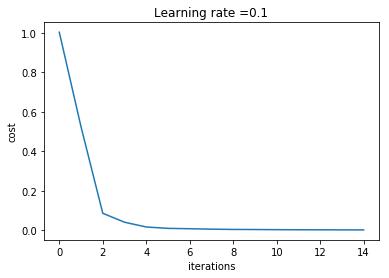

In [8]:
iters = 5
for i in range(iters):
    clr(wait = True)
    print("Remaining iters :", iters-i)
    model.train(X[:,:3], X[:,3].reshape(-1,1), print_cost = True, printerval = 1000)
model.plot_loss_history()

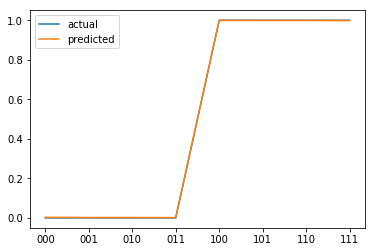

In [9]:
preds = model.predict(X[:,:3])
bool_plot_compare(X[:,3], preds, "01.png")

In [10]:
model.reinit()
X = get_bool_data([0,1,1,0,0,1,1,0])
print_truth_table(X)

inp	| out
--------------
[0 0 0] | 0
[0 0 1] | 1
[0 1 0] | 1
[0 1 1] | 0
[1 0 0] | 0
[1 0 1] | 1
[1 1 0] | 1
[1 1 1] | 0


Remaining iters : 1
Cost after iteration 0: 0.070385
Cost after iteration 1000: 0.046452
Cost after iteration 2000: 0.033455


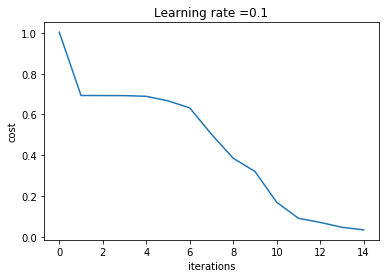

In [11]:
iters = 5
for i in range(iters):
    clr(wait = True)
    print("Remaining iters :", iters-i)
    model.train(X[:,:3], X[:,3].reshape(-1,1), print_cost = True, printerval = 1000)
model.plot_loss_history()

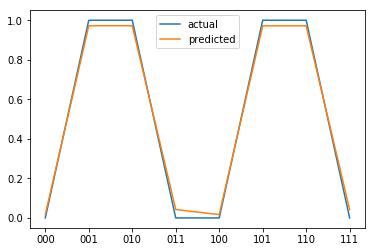

In [12]:
preds = model.predict(X[:,:3])
bool_plot_compare(X[:,3], preds, "02.png")

In [13]:
model.reinit()
X = get_bool_data([0,0,1,1,1,1,0,0])
print_truth_table(X)

inp	| out
--------------
[0 0 0] | 0
[0 0 1] | 0
[0 1 0] | 1
[0 1 1] | 1
[1 0 0] | 1
[1 0 1] | 1
[1 1 0] | 0
[1 1 1] | 0


Remaining iters : 1
Cost after iteration 0: 0.069014
Cost after iteration 1000: 0.045588
Cost after iteration 2000: 0.032869


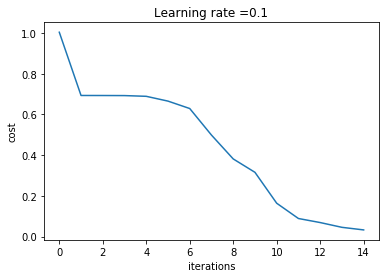

In [14]:
iters = 5
for i in range(iters):
    clr(wait = True)
    print("Remaining iters :", iters-i)
    model.train(X[:,:3], X[:,3].reshape(-1,1), print_cost = True, printerval = 1000)
model.plot_loss_history()

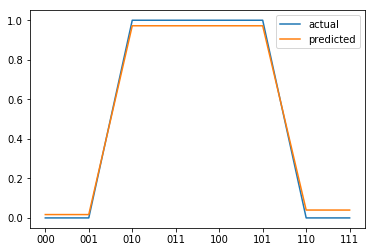

In [15]:
preds = model.predict(X[:,:3])
bool_plot_compare(X[:,3], preds, "03.png")

In [16]:
model.reinit()
X = get_bool_data([0,0,1,0,0,1,0,0])
print_truth_table(X)

inp	| out
--------------
[0 0 0] | 0
[0 0 1] | 0
[0 1 0] | 1
[0 1 1] | 0
[1 0 0] | 0
[1 0 1] | 1
[1 1 0] | 0
[1 1 1] | 0


Remaining iters : 1
Cost after iteration 0: 0.040609
Cost after iteration 1000: 0.034728
Cost after iteration 2000: 0.030125


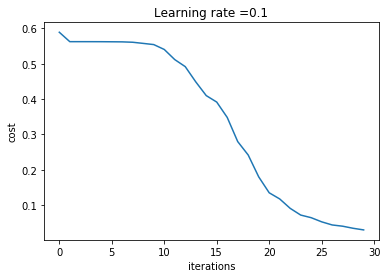

In [17]:
iters = 10
for i in range(iters):
    clr(wait = True)
    print("Remaining iters :", iters-i)
    model.train(X[:,:3], X[:,3].reshape(-1,1), print_cost = True, printerval = 1000)
model.plot_loss_history()

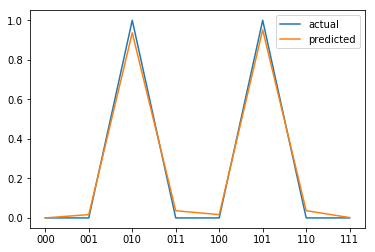

In [18]:
preds = model.predict(X[:,:3])
bool_plot_compare(X[:,3], preds, "04.png")

In [19]:
model.reinit()
X = get_bool_data([1,0,1,0,1,1,0,1])
print_truth_table(X)

inp	| out
--------------
[0 0 0] | 1
[0 0 1] | 0
[0 1 0] | 1
[0 1 1] | 0
[1 0 0] | 1
[1 0 1] | 1
[1 1 0] | 0
[1 1 1] | 1


Remaining iters : 1
Cost after iteration 0: 0.096105
Cost after iteration 1000: 0.065937
Cost after iteration 2000: 0.047306


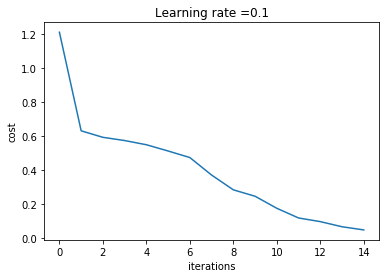

In [20]:
iters = 5
for i in range(iters):
    clr(wait = True)
    print("Remaining iters :", iters-i)
    model.train(X[:,:3], X[:,3].reshape(-1,1), print_cost = True, printerval = 1000)
model.plot_loss_history()

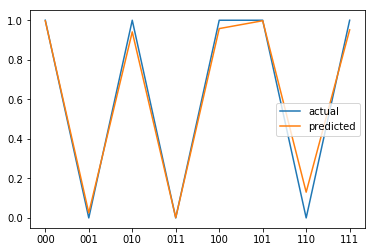

In [21]:
preds = model.predict(X[:,:3])
bool_plot_compare(X[:,3], preds,"05.png")

In [22]:
model.reinit()
X = get_bool_data([0,1,1,1,1,1,1,1])
print_truth_table(X)

inp	| out
--------------
[0 0 0] | 0
[0 0 1] | 1
[0 1 0] | 1
[0 1 1] | 1
[1 0 0] | 1
[1 0 1] | 1
[1 1 0] | 1
[1 1 1] | 1


Remaining iters : 1
Cost after iteration 0: 0.012817
Cost after iteration 1000: 0.010161
Cost after iteration 2000: 0.008306


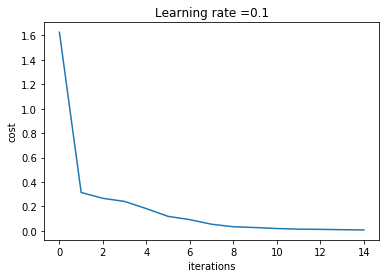

In [23]:
iters = 5
for i in range(iters):
    clr(wait = True)
    print("Remaining iters :", iters-i)
    model.train(X[:,:3], X[:,3].reshape(-1,1), print_cost = True, printerval = 1000)
model.plot_loss_history()

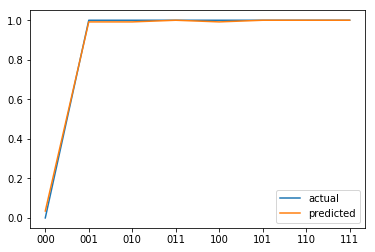

In [24]:
preds = model.predict(X[:,:3])
bool_plot_compare(X[:,3], preds, "06.png")

### Thankyou
Abhishek Kumar

18111002